<a href="https://colab.research.google.com/github/heroza/Experiment-0/blob/main/ISIC%20Dataset%20using%20AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 97% 765M/786M [00:08<00:00, 168MB/s]
100% 786M/786M [00:08<00:00, 99.6MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [5]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
1,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
2,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

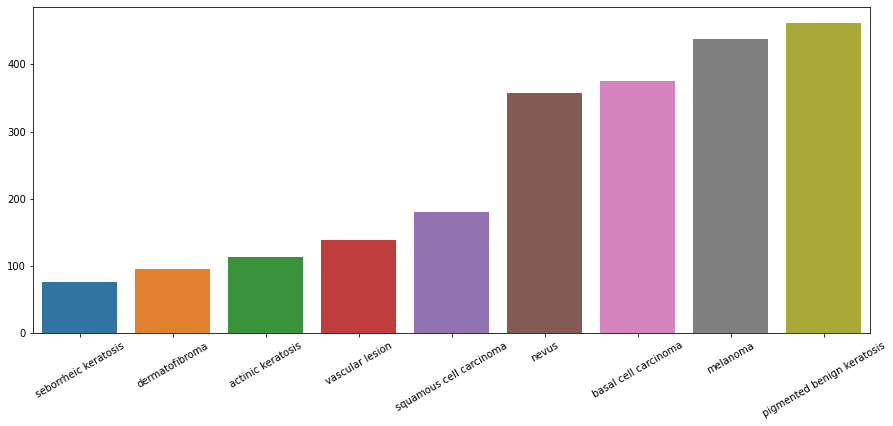

In [6]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

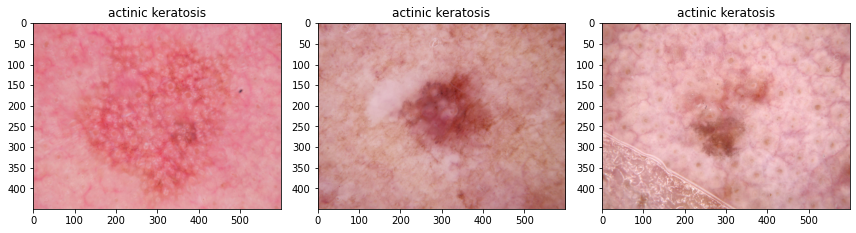

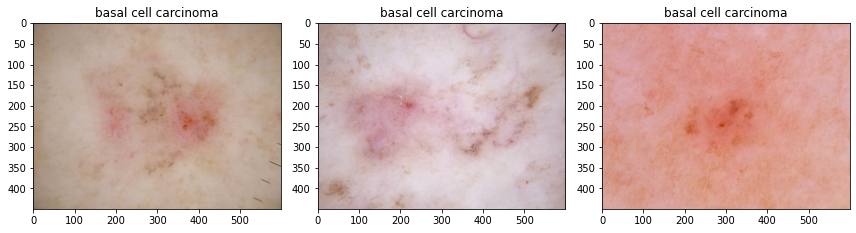

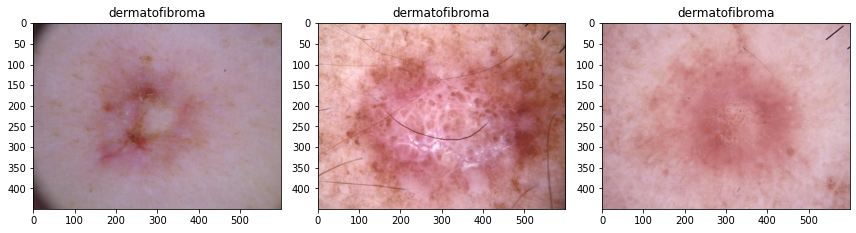

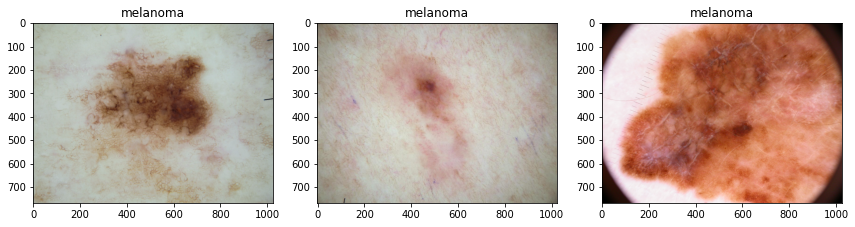

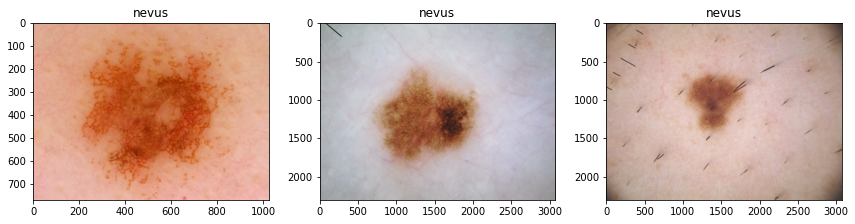

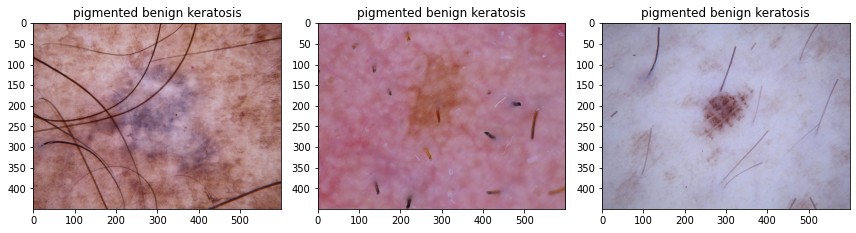

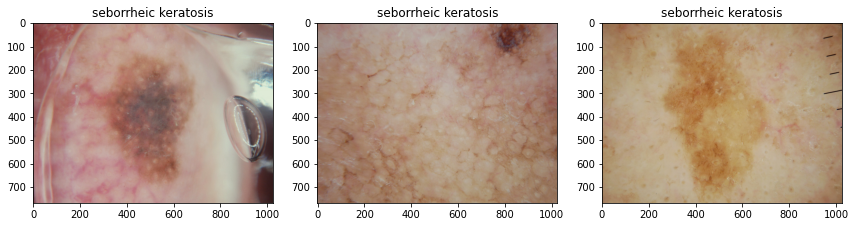

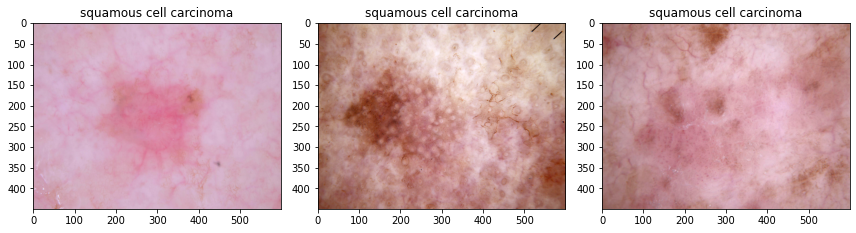

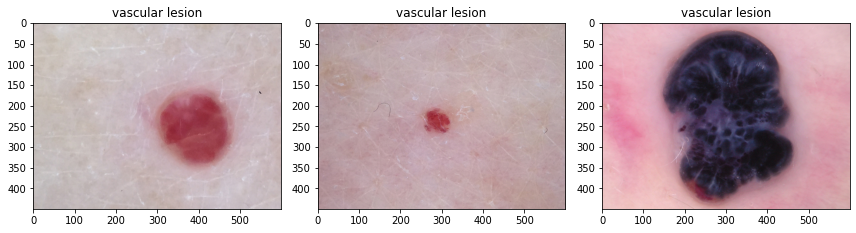

In [7]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Split dataset to train and val

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [10]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [11]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (227,227) #use AlexNet inpu size instead (224, 224)

In [12]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

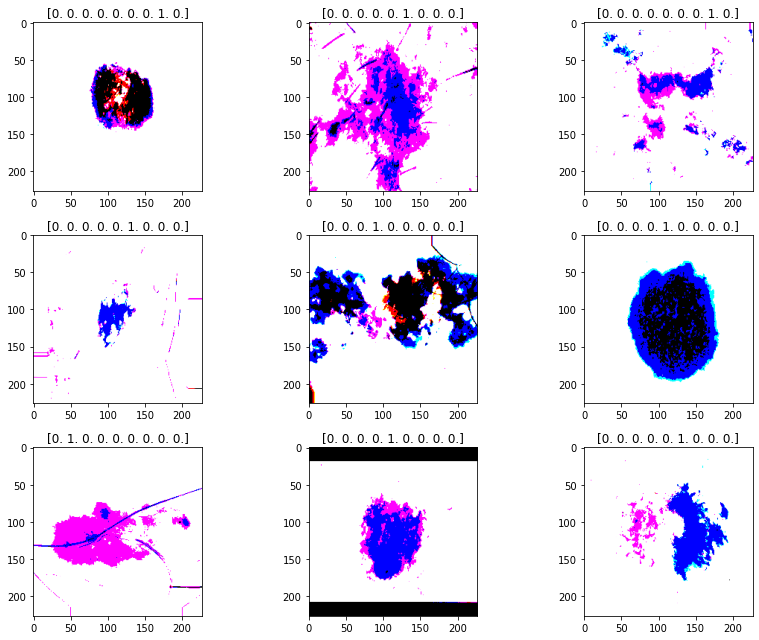

In [13]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

In [14]:
from keras.models import Sequential, load_model
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D

AlexNet Architecture

In [15]:
model = Sequential()
# scale image size to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=96, kernel_size=(11,11), padding='valid', strides=(4,4), input_shape=(227, 227, 3)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(ZeroPadding2D(padding=(2, 2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
#model.add(BatchNormalization())

# 4. Conv2D layer
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5. Conv2D layer
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'))

model.add(Dropout(0.5))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model Training

In [16]:
# count of epchos
EPOCHS = 15

In [17]:
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 57s 972ms/step - loss: 2.2958 - accuracy: 0.2312 - val_loss: 1.9310 - val_accuracy: 0.2455
Epoch 2/15
56/56 [==============================] - 52s 923ms/step - loss: 1.7996 - accuracy: 0.3171 - val_loss: 1.7432 - val_accuracy: 0.3504
Epoch 3/15
56/56 [==============================] - 51s 922ms/step - loss: 1.6869 - accuracy: 0.3685 - val_loss: 1.6180 - val_accuracy: 0.4286
Epoch 4/15
56/56 [==============================] - 52s 931ms/step - loss: 1.6158 - accuracy: 0.4149 - val_loss: 1.8760 - val_accuracy: 0.3192
Epoch 5/15
56/56 [==============================] - 52s 923ms/step - loss: 1.5546 - accuracy: 0.4444 - val_loss: 1.5534 - val_accuracy: 0.4688
Epoch 6/15
56/56 [==============================] - 51s 920ms/step - loss: 1.5404 - accuracy: 0.4545 - val_loss: 1.4807 - val_accuracy: 0.4799
Epoch 7/15
56/56 [==============================] - 53s 947ms/step - loss: 1.4148 - accuracy: 0.4886 - val_loss: 1.4480 - val_accuracy: 0.5201

Save the model

In [18]:
#model.save_weights('model-alexnet',save_format='tf')

In [19]:
#model.save('/content/drive/MyDrive/PHD/Model/model-alexnet')

Load the model

In [20]:
#model = load_model('/content/drive/MyDrive/PHD/Model/model-alexnet')

In [21]:
#model.load_weights('model')
#model.summary()

Plot the performance of val vs training set

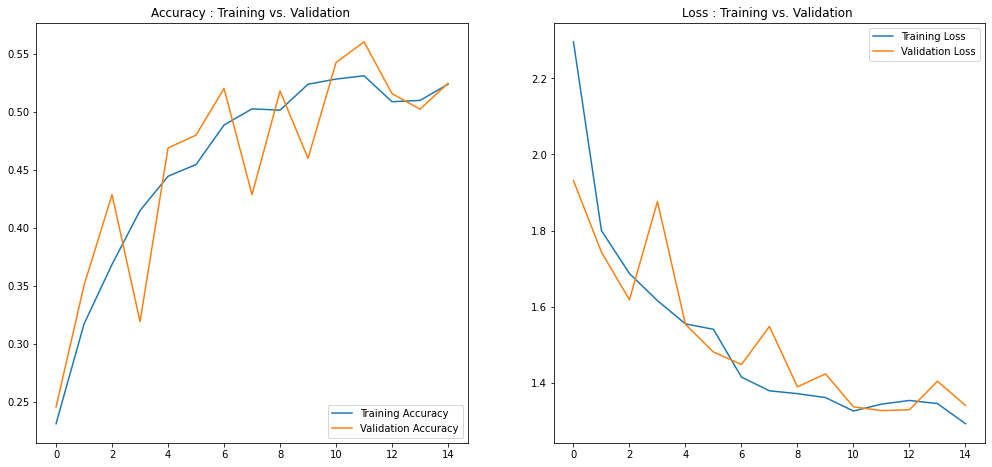

In [22]:
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 17))
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

Load test data

In [23]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [24]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
1,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2,Skin cancer ISIC The International Skin Imagin...,nevus


In [25]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


seborrheic keratosis           3
vascular lesion                3
pigmented benign keratosis    16
nevus                         16
melanoma                      16
actinic keratosis             16
basal cell carcinoma          16
squamous cell carcinoma       16
dermatofibroma                16
Name: Labels, dtype: int64

Preprocess test image

In [26]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


Evaluate model againts test data

In [27]:
res = model.evaluate(X_test)

4/4 [==============================] - 8s 2s/step - loss: 2.1012 - accuracy: 0.3475


The accuracy

In [28]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 52.37
Val Accuracy: 52.46
Test Accuracy: 34.75
Train Loss: 129.23
Val Loss: 134.04
Test Loss: 210.12


Calculate y_pred

In [29]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


Calculate y_true

In [30]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9


The confusion metric

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

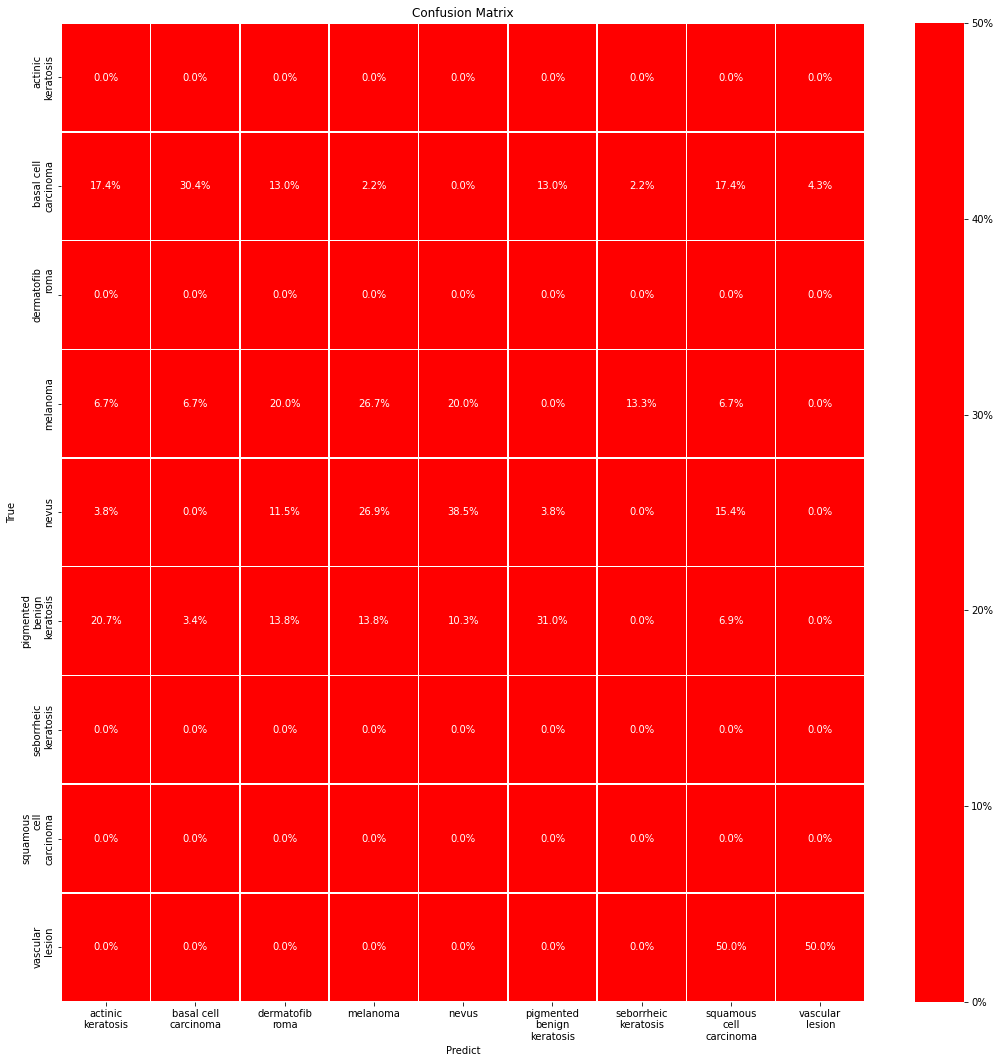

In [32]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])